<a href="https://colab.research.google.com/github/jhcleary/RFirstProjects/blob/master/Week_7_End_to_End_ML_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 7 Lab: End-to-End ML Development

# Customer Churn Data ML Pipeline

In the following section we will use what we've learned in class and in the previous lecture to build a machine learning pipeline for the churn prediction problem.

In [ ]:
# Import the necessary libraries and datasets
from google.colab import files
# Select telecom_customer_churn.csv and telecom_zipcode_population.csv
uploaded = files.upload()

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       935
           1       0.85      0.70      0.77       383

    accuracy                           0.88      1318
   macro avg       0.87      0.82      0.84      1318
weighted avg       0.87      0.88      0.87      1318

Best Model: XGBoost
Best Model Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
F1 Score: 0.87
Accuracy: 0.88
Precision: 0.87
Recall: 0.88


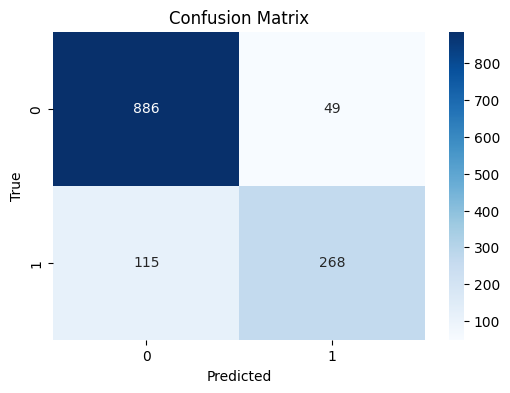

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings from the models
warnings.filterwarnings('ignore', category=UserWarning)

# Load the dataset
data = pd.read_csv('telecom_customer_churn.csv')

#################
# Data Cleaning #
#################

# Step 1: Drop specified columns
data.drop(['Customer ID', 'City', 'Total Refunds', 'Zip Code', 'Latitude', 'Longitude', 'Churn Category', 'Churn Reason'],
          axis='columns', inplace=True)

# Step 2: Clean column names
data.columns = data.columns.str.replace(" ", "_").str.lower()

# Step 3: Remove the "joined" category to avoid recency bias
data = data[data["customer_status"] != "Joined"]

# Step 4: Binarize target variable
data['customer_status'].replace({'Stayed':0, 'Churned':1}, inplace=True)

######################
# Data Preprocessing #
######################

# Define features and target
X = data.drop(columns=["customer_status"])
y = data["customer_status"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

###################
# Model Selection #
###################

# Define the classifiers and their specific parameter grids
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    })
}

# Pipeline and GridSearchCV
results = {}
best_model = None
best_score = 0
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    search.fit(X_train, y_train)
    results[name] = search

    # Check if this model is the best so far
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_model_name = name

##############
# Evaluation #
##############

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print all metrics
print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {best_params}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Looks like the XGBoost model has the best metrics! The approach above works great most times when we know exactly what the evaluation metrics are with clear cost functions for the erroneous model predictions. However, when the costs aren't directly tied to conventional metrics such as accuracy, precision, or recall, the expected business value framework would be a better choice.

### Expected Business Value Approach

Let's explore the same problem from a business perspective as outline in class.

In [ ]:
def calculate_expected_profit(tp, fp, voucher_cost, customer_value):
    # Profit from saving customers who would have churned
    profit_from_saved_customers = tp * customer_value

    # Cost from vouchers given to customers (both true positives and false positives)
    total_voucher_cost = (tp + fp) * voucher_cost

    # Net profit
    expected_profit = profit_from_saved_customers - total_voucher_cost
    return expected_profit


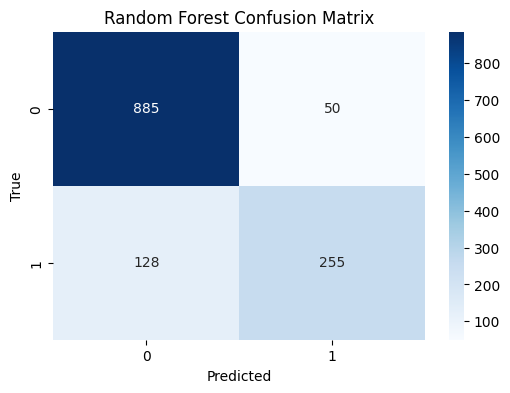

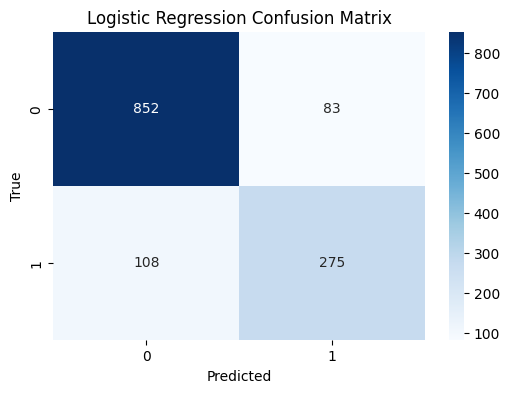

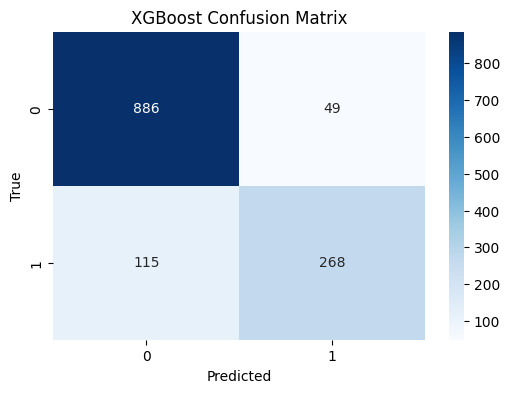

,Model Name,Weighted Accuracy,Weighted F1 Score,Weighted Precision,Weighted Recall,Expected Profit/Loss
0,Random Forest,0.864947,0.859995,0.862723,0.864947,1244500
1,Logistic Regression,0.855083,0.853595,0.852820,0.855083,1339200
2,XGBoost,0.875569,0.871824,0.873582,0.875569,1308300


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

random_state=42

# Suppress warnings from the models
warnings.filterwarnings('ignore', category=UserWarning)

# Load the dataset
data = pd.read_csv('telecom_customer_churn.csv')

#################
# Data Cleaning #
#################

# Step 1: Drop specified columns
data.drop(['Customer ID', 'City', 'Total Refunds', 'Zip Code', 'Latitude', 'Longitude', 'Churn Category', 'Churn Reason'],
          axis='columns', inplace=True)

# Step 2: Clean column names
data.columns = data.columns.str.replace(" ", "_").str.lower()

# Step 3: Remove the "joined" category to avoid recency bias
data = data[data["customer_status"] != "Joined"]

# Step 4: Binarize target variable
data['customer_status'].replace({'Stayed':0, 'Churned':1}, inplace=True)

######################
# Data Preprocessing #
######################

# Define features and target
X = data.drop(columns=["customer_status"])
y = data["customer_status"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

###################
# Model Selection #
###################

# Define the classifiers and their specific parameter grids
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    })
}

# Pipeline and GridSearchCV
results = {}
results_table = []
best_model = None
best_score = 0
expected_profit = 0
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    search.fit(X_train, y_train)
    results[name] = search

# Iterate over each model to perform evaluation and calculate business impact

    # Generate predictions and compute confusion matrix
    y_pred = search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
    tp = cm[1, 1]
    fp = cm[0, 1]
    total_customers = len(y_test)

    # Calculate business metrics
    model_expected_profit = calculate_expected_profit(tp, fp, 100, 5000)
    # Check if this model is the best so far
    if model_expected_profit > expected_profit:
        expected_profit = model_expected_profit
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_model_name = name

    # Extract classification report for weighted metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_accuracy = report['accuracy']
    weighted_f1 = report['weighted avg']['f1-score']
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']

    # Append results to table
    results_table.append({
        'Model Name': name,
        'Weighted Accuracy': weighted_accuracy,
        'Weighted F1 Score': weighted_f1,
        'Weighted Precision': weighted_precision,
        'Weighted Recall': weighted_recall,
        'Expected Profit/Loss': model_expected_profit
    })
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results_table)
results_df


When we defined clear business value based on our unique use case and assigned weights/costs to the error rates, the best performing model expected to bring the highest incremental profits turned out to be the simplest: **logistic regression**!

In [ ]:
from joblib import dump

# Save the best model to disk
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.joblib'
dump(best_model, model_filename)
print(f"Model saved as {model_filename}")